In [1]:
import os
import gc
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random
from scipy.ndimage import gaussian_filter, map_coordinates
from skimage import img_as_float, img_as_ubyte

from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

In [2]:
# Load videos and split in 30 frames
def load_video(video_path, num_frames=30):
    # Capture video
    vidcap = cv2.VideoCapture(video_path)
    # Determine the total number of frames in the video
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    # Calculate the interval for frame sampling
    frame_interval = max(1, total_frames // num_frames)
    
    frames = []  # List to store selected frames
    count = 0  # Frame counter

    # Use a while loop to read frames from the video
    while True:
        success, frame = vidcap.read()
        
        # Break the loop if there are no more frames
        if not success:
            break

        # Sample frames based on the calculated interval
        if count % frame_interval == 0 and len(frames) < num_frames:
            frames.append(frame)
        
        # Break the loop if we have collected the desired number of frames
        if len(frames) == num_frames:
            break

        count += 1

    # Release the video capture object
    vidcap.release()

    # Convert the list of frames to a numpy array for convenience if required
    # frames = np.array(frames)
    return frames


In [94]:
# Example usage
video_path = os.path.join(video_folder, "0901_flickr-8-9-5-10477544895_6.mp4")
frames = load_video(video_path)
print(f"Collected {len(frames)} frames.")
print(np.array(frames).shape)

Collected 30 frames.
(30, 268, 268, 3)


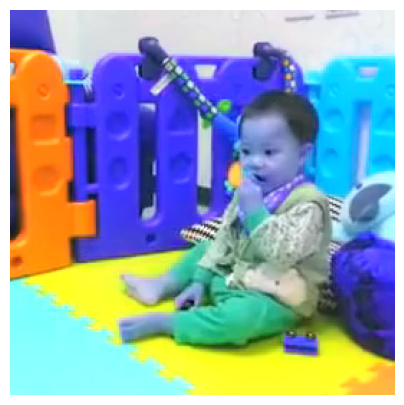

In [14]:
plt.figure(figsize=(5, 5))
plt.imshow(frames[0].astype('uint8'))  # Ensure the image is displayed correctly
plt.axis('off')  # Hide axes for better visualization
plt.show()

In [3]:
def rotate_frame(frame, angle, scale=1.0):
    """
    Rotate the frame by a certain angle.

    Parameters:
    - frame: Input image/frame.
    - angle: Rotation angle in degrees. Positive values mean counter-clockwise rotation.
    - scale: Isotropic scale factor.

    Returns:
    - Rotated frame.
    """
    height, width = frame.shape[:2]
    center = (width / 2, height / 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)
    rotated_frame = cv2.warpAffine(frame, rotation_matrix, (width, height))
    return rotated_frame

def flip_frame(frame, flip_code):
    """
    Flip the frame.

    Parameters:
    - frame: Input image/frame.
    - flip_code: Flip code. 0 for vertical flip, 1 for horizontal flip, -1 for both.

    Returns:
    - Flipped frame.
    """
    flipped_frame = cv2.flip(frame, flip_code)
    return flipped_frame

def generate_displacement_fields(shape, alpha, sigma, random_state=None):
    """
    Generate consistent displacement fields for elastic deformation.

    Parameters:
    - shape: The shape of the frames (height, width).
    - alpha: Intensity of the deformation.
    - sigma: Standard deviation of the Gaussian filter used in deformation.
    - random_state: Optional random state for reproducibility.

    Returns:
    - dx: Displacement field for the X direction.
    - dy: Displacement field for the Y direction.
    """
    if random_state is None:
        random_state = np.random.RandomState()
        
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    
    return dx, dy

def elastic_deform_frame(frame, dx, dy):
    """
    Apply elastic deformation to a 3D frame (RGB) using pre-generated displacement fields.
    
    Parameters:
    - frame: Input frame (3D numpy array).
    - dx: Pre-generated displacement field for the X direction.
    - dy: Pre-generated displacement field for the Y direction.
    
    Returns:
    - Deformed frame (3D numpy array).
    """
    assert len(frame.shape) == 3  # Ensure frame is 3D
    
    deformed_frame = np.empty_like(frame)
    for i in range(frame.shape[2]):  # Apply deformation to each channel
        deformed_frame[..., i] = map_coordinates(frame[..., i], (np.indices(frame.shape[:2]) + [dy, dx]), order=1, mode='reflect')
    
    return deformed_frame

Augmentation examples

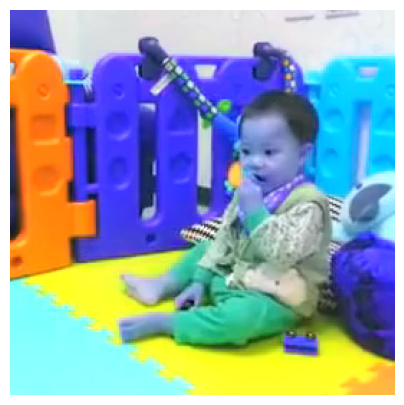

In [43]:
# original
plt.figure(figsize=(5, 5))
plt.imshow(frames[0].astype('uint8'))  # Ensure the image is displayed correctly
plt.axis('off')  # Hide axes for better visualization
plt.show()

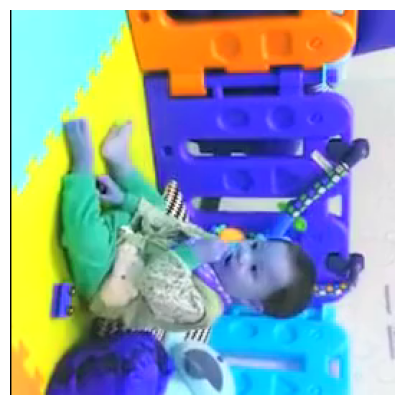

In [63]:
rotated_frame = rotate_frame(frames[0], 270)
plt.figure(figsize=(5, 5))
plt.imshow(rotated_frame.astype('uint8'))  # Ensure the image is displayed correctly
plt.axis('off')  # Hide axes for better visualization
plt.show()

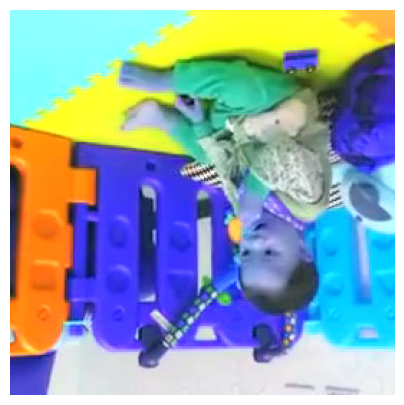

In [65]:
flipped_frame = flip_frame(frames[0], 0)
plt.figure(figsize=(5, 5))
plt.imshow(flipped_frame.astype('uint8'))  # Ensure the image is displayed correctly
plt.axis('off')  # Hide axes for better visualization
plt.show()

In [90]:
# Initialize random state for reproducibility
random_state = np.random.RandomState(seed=42)

# Generate displacement fields once
shape = (268, 268)  # Set the height and width of your frames
dx, dy = generate_displacement_fields(shape, alpha=200, sigma=10, random_state=random_state)

# Deform each frame using the same displacement fields
deformed_frames = [elastic_deform_frame(frame, dx, dy) for frame in frames[:2]]


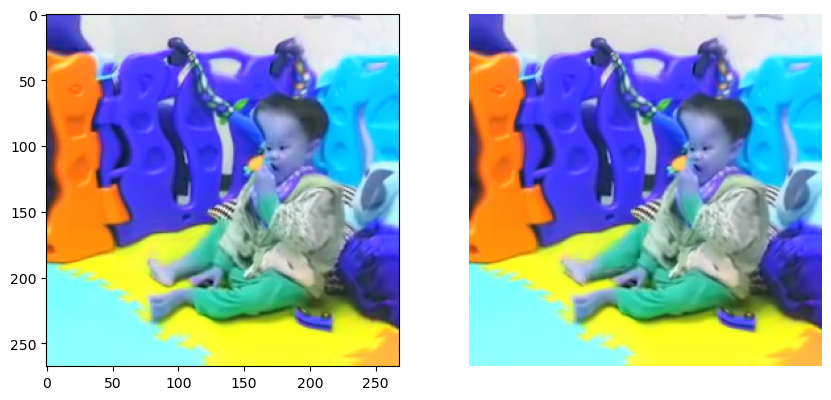

In [91]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(deformed_frames[0].astype('uint8'))  # Ensure the image is displayed correctly
plt.axis('off')

axs[1].imshow(deformed_frames[1].astype('uint8'))  # Ensure the image is displayed correctly
plt.axis('off')

plt.show()

In [4]:
def preprocess_video(frames, target_size=(224, 224), transformation=None):
    """
    Preprocess and apply transformations to video frames.

    Parameters:
    - frames: A numpy array of frames.
    - target_size: Target size (width, height) for resizing frames.
    - transformation: Type of transformation ('rotation', 'flipping', 'deformation').
    - **kwargs: Additional arguments for the transformation functions.
    
    Returns:
    - preprocessed_frames: A numpy array of transformed frames.
    """
    # Apply specified transformation
    if transformation == 'rotation':
        # randomly generate angle
        angle = random.choice([90, 180, 270])
        # rotate frames
        transformed_frames = [rotate_frame(frame, angle) for frame in frames]
        
    elif transformation == 'flipping':
        # randomly generate flipping axis
        flip_code = random.choice([0,1,-1])
        # flip frames
        transformed_frames = [flip_frame(frame, flip_code) for frame in frames]
        
    elif transformation == 'deformation':
        # randomly generate deformation strength alpha (100-150) and sigma (10-15)
        random_state = np.random.RandomState(seed=42)
        shape = (np.array(frames).shape[1], np.array(frames).shape[2])
        alpha = random.randint(100, 150)
        sigma = random.randint(10, 15)
        dx, dy = generate_displacement_fields(shape, alpha=alpha, sigma=sigma, random_state=random_state)
        # deform frames
        transformed_frames = [elastic_deform_frame(frame, dx, dy) for frame in frames]
    
    # Preprocess frames for resnet50
    preprocessed_frames = []
    for frame in transformed_frames:
        frame = cv2.resize(frame, target_size)
        frame = np.expand_dims(frame, axis=0)
        frame = preprocess_input(frame)
        preprocessed_frames.append(frame)
    
    return preprocessed_frames

In [106]:
preprocessed_frames = preprocess_video(frames, transformation='deformation')
print(len(preprocessed_frames))
print(np.array(preprocessed_frames).shape)

30
(30, 1, 224, 224, 3)


In [5]:
def extract_features(preprocessed_frames, base_model):   
    # Preprocessed frames are in 'preprocessed_frames'
    # Assuming 'preprocessed_frames' is a list of frames that have already been preprocessed
    
    # Initialize a dictionary to hold features from each stage
    features_per_stage = {stage: [] for stage in layers_to_extract}
    
    # Extract and store features for each stage
    for frame in preprocessed_frames:
        for stage, model in models.items():
            stage_features = model.predict(frame)  # img is already preprocessed and ready for prediction
            features_per_stage[stage].append(stage_features)
    
    # Stack features for 3D input if necessary
    stacked_features = {stage: np.vstack(features) for stage, features in features_per_stage.items()}
    
    return stacked_features

In [111]:
base_model = ResNet50(weights='imagenet', include_top=False)
stacked_features = extract_features(preprocessed_frames, base_model)

1/1 [==============================] - 0s 108ms/step


In [114]:
for key, value in stacked_features.items():
    print(f"Shape of '{key}': {value.shape}")

Shape of 'conv4_block6_out': (30, 14, 14, 1024)
Shape of 'conv5_block3_out': (30, 7, 7, 2048)


In [12]:
def process_batch(batch, input_folder, stage_folders):
    for filename in batch:
        video_id = filename[:4]

        # Check if the file for this video ID already exists in any stage folder
        if file_exists(video_id, stage_folders):
            print(f"Files for video ID {video_id} already exist. Skipping.")
            continue

        video_path = os.path.join(input_folder, filename)
        try:
            frames = load_video(video_path)
            preprocessed_frames = preprocess_video(frames, transformation='flipping')
            stacked_features = extract_features(preprocessed_frames, base_model)
            
            if not isinstance(stacked_features, dict):
                raise ValueError(f"Unexpected data format for {filename}: {type(stacked_features)}")

            video_id = filename[:4]
            for stage, features in stacked_features.items():
                stage_folder = os.path.join(output_folder, stage)
                if not os.path.exists(stage_folder):
                    os.makedirs(stage_folder)
                    print(f"Created folder: {stage_folder}")

                output_file = os.path.join(stage_folder, f"{video_id}_{stage}.pkl")
                with open(output_file, 'wb') as file:
                    pickle.dump(features, file)
                    print(f"Saved file: {output_file}")

        except Exception as e:
            print(f"Error processing {filename}: {e}, data type: {type(stacked_features)}")
            
        finally:
            # Explicitly delete large variables
            del stacked_features
            # Call garbage collector
            gc.collect()


def file_exists(video_id, stage_folders):
    """Check if a file for the given video ID already exists in any of the stage folders."""
    for stage in stage_folders:
        filepath = os.path.join(stage_folders[stage], f"{video_id}_{stage}.pkl")
        if os.path.exists(filepath):
            return True
    return False

def process_and_save_videos(input_folder, output_folder, batch_size=100, id_range=None):
    # Ensure output folder exists and create a dictionary for stage folders
    stage_folders = {}
    stages = ['stage_4', 'stage_5'] # 'stage_1', 'stage_2', 'stage_3',
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for stage in stages:
        stage_folder = os.path.join(output_folder, stage)
        stage_folders[stage] = stage_folder
        if not os.path.exists(stage_folder):
            os.makedirs(stage_folder)

    # Get all MP4 files
    all_files = [f for f in os.listdir(input_folder) if f.endswith(".mp4")]

    # Filter files based on ID range if provided
    if id_range is not None:
        start_id, end_id = id_range
        all_files = [f for f in all_files if start_id <= f[:4] <= end_id]

    # Process in batches
    for i in range(0, len(all_files), batch_size):
        batch = all_files[i:i + batch_size]
        process_batch(batch, input_folder, stage_folders)  # Pass 'stage_folders' instead of 'output_folder'
        print(f"Processed batch {i // batch_size + 1}/{(len(all_files) - 1) // batch_size + 1}")



In [7]:
# Initialize ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False)

# Select layers for feature extraction at the end of each stage
layers_to_extract = {
    # 'stage_1': base_model.get_layer('pool1_pool').output,
    # 'stage_2': base_model.get_layer('conv2_block3_out').output,
    # 'stage_3': base_model.get_layer('conv3_block4_out').output,
    'stage_4': base_model.get_layer('conv4_block6_out').output,
    'stage_5': base_model.get_layer('conv5_block3_out').output
}

# Create models for each stage
models = {stage: Model(inputs=base_model.input, outputs=output) for stage, output in layers_to_extract.items()}

In [13]:
input_folder = "AlgonautsVideos268_All_30fpsmax"  # Update with your input folder path
output_folder = 'preprocessed_videos_30frames_transformed/flipped'  # Update with your output folder path
batch_size = 50   # Adjust based on your system's capability
id_range = ('0901', '1000')  # Process videos with IDs from 1000 to 2000
process_and_save_videos(input_folder, output_folder, batch_size, id_range)

1/1 [==============================] - 0s 94ms/step
Saved file: preprocessed_videos_30frames_transformed/flipped\stage_4\0901_stage_4.pkl
Saved file: preprocessed_videos_30frames_transformed/flipped\stage_5\0901_stage_5.pkl
1/1 [==============================] - 0s 94ms/step
Saved file: preprocessed_videos_30frames_transformed/flipped\stage_4\0902_stage_4.pkl
Saved file: preprocessed_videos_30frames_transformed/flipped\stage_5\0902_stage_5.pkl
1/1 [==============================] - 0s 94ms/step
Saved file: preprocessed_videos_30frames_transformed/flipped\stage_4\0903_stage_4.pkl
Saved file: preprocessed_videos_30frames_transformed/flipped\stage_5\0903_stage_5.pkl
1/1 [==============================] - 0s 94ms/step
Saved file: preprocessed_videos_30frames_transformed/flipped\stage_4\0904_stage_4.pkl
Saved file: preprocessed_videos_30frames_transformed/flipped\stage_5\0904_stage_5.pkl
1/1 [==============================] - 0s 78ms/step
Saved file: preprocessed_videos_30frames_transformed